# Runtime Analysis
This notebook is designed to compare output two or more ACCESS-OM2 simulations. 

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36877 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 48 Memory: 202.48 GB


In [3]:
session = cc.database.create_session('ryf9091.db')

In [4]:
exptdict = OrderedDict([
    ('01deg_RYF9091',   {'expt':'01deg_jra55v13_ryf9091','dir':'access-om2-01'}),
    ('01deg_RYF8485',   {'expt':'01deg_jra55v13_ryf8485_spinup6','dir':'access-om2-01'}),
    ('025deg_RYF9091',  {'expt':'025deg_jra55v13_ryf9091_gmredi6','dir':'access-om2-025'})
                        ])

In [5]:
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    dir = exptdict[ekey]['dir']
    cc.database.build_index('/g/data/hh5/tmp/cosima/'+dir+'/'+expt,session,update=True)

Indexing experiment: 01deg_jra55v13_ryf9091


100%|██████████| 17/17 [00:00<00:00, 24.83it/s]


Indexing experiment: 01deg_jra55v13_ryf8485_spinup6


0it [00:00, ?it/s]


Indexing experiment: 025deg_jra55v13_ryf9091_gmredi6


0it [00:00, ?it/s]


## Scalar diagnostics

In [6]:
def plot_timeseries(variable):
    plt.figure(figsize=(10,5))
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session)
        var.resample(time='Y').mean().plot(label=ekey)
    plt.title(variable)
    plt.legend()
    return

### Global Average Temperature

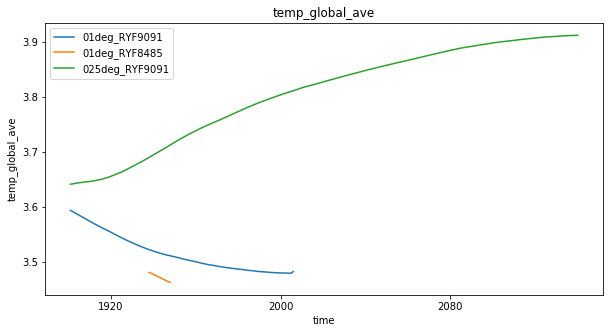

In [7]:
plot_timeseries('temp_global_ave')

### Global Average Salinity

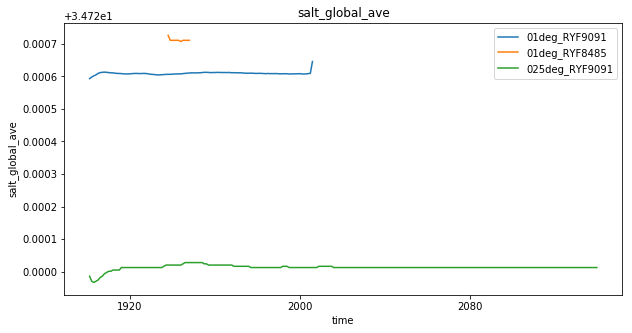

In [8]:
plot_timeseries('salt_global_ave')

### Surface Temperature

CPU times: user 12.9 s, sys: 739 ms, total: 13.6 s
Wall time: 23.3 s


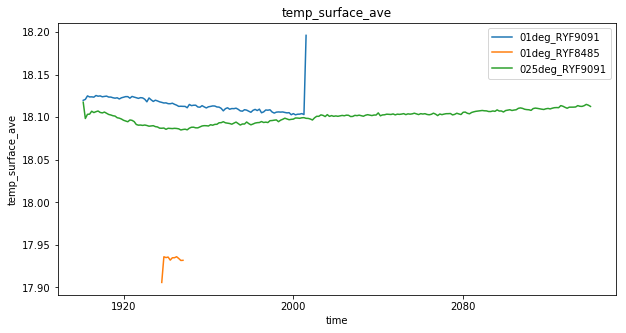

In [9]:
%%time
plot_timeseries('temp_surface_ave')

### Surface Salinity

CPU times: user 13.4 s, sys: 832 ms, total: 14.2 s
Wall time: 24.2 s


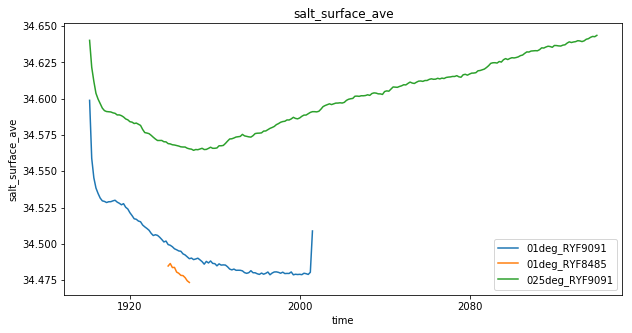

In [10]:
%%time
plot_timeseries('salt_surface_ave')

### Total Kinetic Energy

CPU times: user 13.6 s, sys: 857 ms, total: 14.4 s
Wall time: 24.4 s


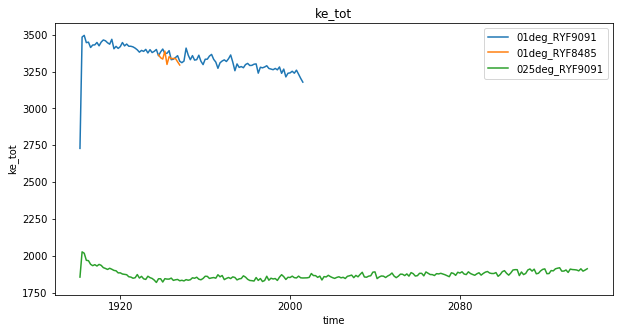

In [11]:
%%time
plot_timeseries('ke_tot')

## Area-Averaged Tracer Diagnostics

In [6]:
def plot_upper_ocean(variable):
    plt.figure(figsize=(10,5))
    zlevel = 1000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc')
        varmean = var.sel(st_ocean = slice(0,zlevel)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Upper Ocean (< '+str(zlevel)+') '+variable)

### Upper Ocean Temperature/Salinity

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf8485_spinup6
025deg_jra55v13_ryf9091_gmredi6
CPU times: user 25min 24s, sys: 1min 18s, total: 26min 42s
Wall time: 36min 23s


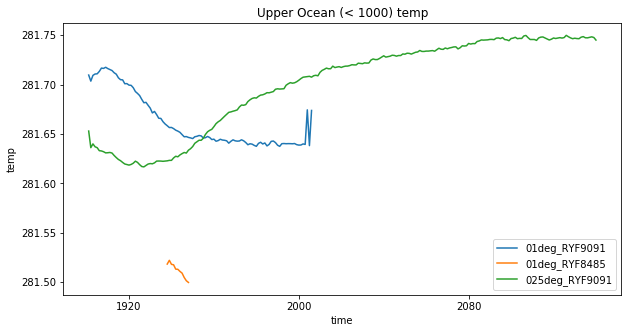

In [24]:
%%time
plot_upper_ocean('temp')

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf8485_spinup6
025deg_jra55v13_ryf9091_gmredi6
CPU times: user 26min 46s, sys: 1min 39s, total: 28min 26s
Wall time: 37min 33s


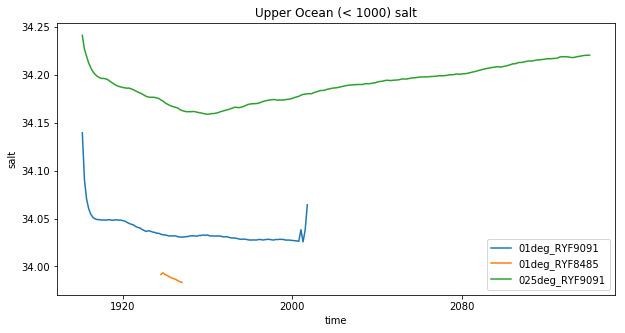

In [7]:
%%time
plot_upper_ocean('salt')

### Deep Ocean Temperature/Salinity

In [20]:
def plot_lower_ocean(variable):
    plt.figure(figsize=(10,5))
    zlevel = 3000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc')
        varmean = var.sel(st_ocean = slice(zlevel,None)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Deep Ocean (> '+str(zlevel)+') '+variable)
    

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf8485_spinup6
025deg_jra55v13_ryf9091_gmredi6
CPU times: user 11min 22s, sys: 34.2 s, total: 11min 57s
Wall time: 15min 56s


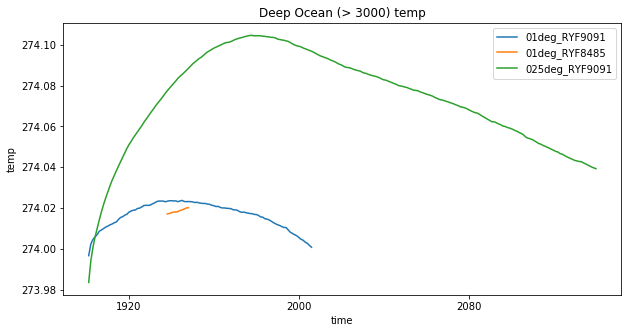

In [21]:
%%time
plot_lower_ocean('temp')

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf8485_spinup6
025deg_jra55v13_ryf9091_gmredi6
CPU times: user 11min 40s, sys: 34.5 s, total: 12min 15s
Wall time: 16min 31s


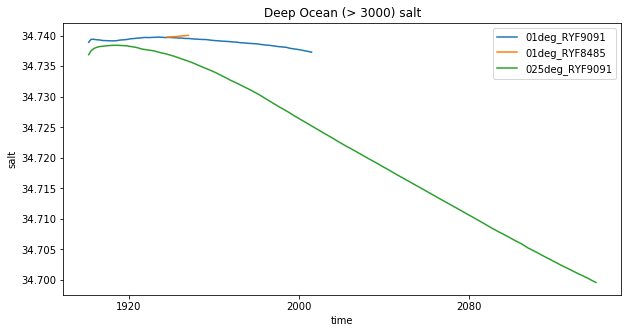

In [22]:
%%time
plot_lower_ocean('salt')

## Circulation Diagnostics

### Drake Passage Transport

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf8485_spinup6
025deg_jra55v13_ryf9091_gmredi6


Text(0.5,1,'ACC Transport')

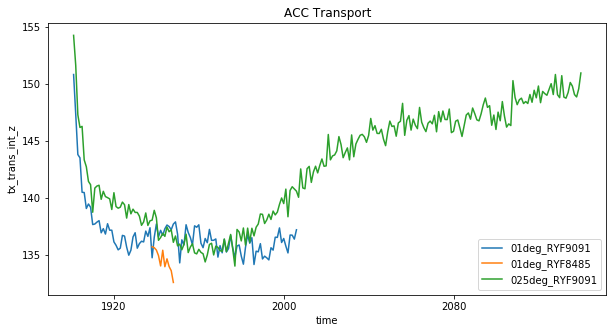

In [12]:
xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("ACC Transport")

### AABW overturning circulation @ 55°S

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf8485_spinup6
025deg_jra55v13_ryf9091_gmredi6


Text(0.5,1,'AABW Cell')

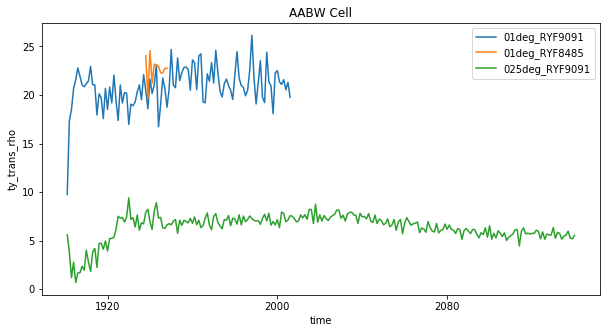

In [18]:
latitude=-55
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    psi_aabw_sum.plot(label=ekey)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

01deg_jra55v13_ryf9091
01deg_jra55v13_ryf8485_spinup6
025deg_jra55v13_ryf9091_gmredi6


Text(0.5,1,'AMOC Cell')

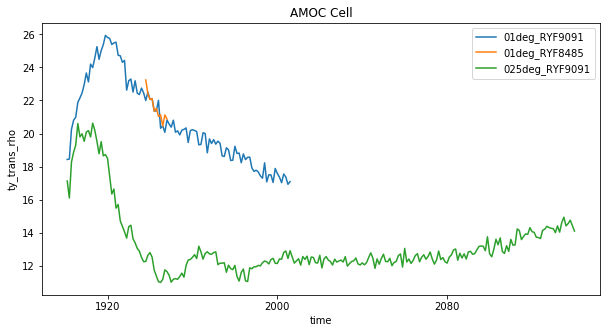

In [19]:
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey)
plt.legend()
plt.title('AMOC Cell')

### Ice Area (in both hemispheres)

In [ ]:
variable='aice_m'
plt.figure(figsize=(10,9))
ax = plt.subplots(2,1)
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session)
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean').load()
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean')
    NH_area.plot(ax=ax[0],label=ekey)
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean')
    SH_area.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

### Ice volume (in both hemispheres)

In [ ]:
variable='vicen_m'
plt.figure(figsize=(10,9))
ax = plt.subplots(2,1)
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session)
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc').load()
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean')
    NH_vol.plot(ax=ax[0],label=ekey)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean')
    SH_vol.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')